<a href="https://colab.research.google.com/github/Bandavinay/Data-structures-algorithms-project-/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. Download Libraries

In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")


3. Load Datasets

In [ ]:
# Load your CSV files (update paths if needed)
btc = pd.read_csv('/content/Bitcoin Historical Data (8).csv')
spx = pd.read_csv('/content/S&P 500 Historical Data (6).csv')
dxy = pd.read_csv('/content/US Dollar Index Historical Data (3).csv')
gold = pd.read_csv('/content/XAG_USD Historical Data (1).csv')
silver = pd.read_csv('/content/XAU_USD Historical Data (2).csv')


🕒 4. Parse Dates and Set Index

In [ ]:
# Convert 'Date' to datetime and use it as index
for df in [btc, spx, dxy, gold, silver]:
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df.set_index('Date', inplace=True)


📅 5. Create Date Range and Reindex

In [ ]:
# Create a consistent date range and reindex all datasets
start_date = min(df.index.min() for df in [btc, spx, dxy, gold, silver])
end_date = max(df.index.max() for df in [btc, spx, dxy, gold, silver])
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

for i, df in enumerate([btc, spx, dxy, gold, silver]):
    df = df.reindex(date_range)
    if i == 0: btc = df
    elif i == 1: spx = df
    elif i == 2: dxy = df
    elif i == 3: gold = df
    else: silver = df


🔗 6. Merge All Datasets

In [ ]:
# Merge all datasets on their date index
merged_data = btc.merge(spx, left_index=True, right_index=True, how='outer', suffixes=('_btc', '_spx'))
merged_data = merged_data.merge(dxy, left_index=True, right_index=True, how='outer', suffixes=('', '_dxy'))
merged_data = merged_data.merge(gold, left_index=True, right_index=True, how='outer', suffixes=('', '_gold'))
merged_data = merged_data.merge(silver, left_index=True, right_index=True, how='outer', suffixes=('', '_silver'))


🏷️ 7. Rename and Clean Columns

In [ ]:
# Rename columns for clarity
merged_data.columns = ['BTC_Price', 'BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Vol', 'BTC_Change%',
                       'SPX_Price', 'SPX_Open', 'SPX_High', 'SPX_Low', 'SPX_Vol', 'SPX_Change%',
                       'DXY_Price', 'DXY_Open', 'DXY_High', 'DXY_Low', 'DXY_Vol', 'DXY_Change%',
                       'Gold_Price', 'Gold_Open', 'Gold_High', 'Gold_Low', 'Gold_Vol', 'Gold_Change%',
                       'Silver_Price', 'Silver_Open', 'Silver_High', 'Silver_Low', 'Silver_Vol', 'Silver_Change%']

# Drop unneeded volume columns
merged_data.drop(columns=['SPX_Vol', 'DXY_Vol', 'Gold_Vol', 'Silver_Vol'], inplace=True)


🔢 8. Convert Prices to Numeric

In [ ]:
# Convert price and open/high/low columns to float
price_cols = ['BTC_Price', 'BTC_Open', 'BTC_High', 'BTC_Low',
              'SPX_Price', 'SPX_Open', 'SPX_High', 'SPX_Low',
              'DXY_Price', 'DXY_Open', 'DXY_High', 'DXY_Low',
              'Gold_Price', 'Gold_Open', 'Gold_High', 'Gold_Low',
              'Silver_Price', 'Silver_Open', 'Silver_High', 'Silver_Low']

for col in price_cols:
    merged_data[col] = merged_data[col].astype(str).str.replace(',', '')
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')


📊 9. Convert BTC Volume

In [ ]:
# Convert BTC volume from string to number (B/M/K notation)
def convert_volume(vol_str):
    if pd.isna(vol_str): return np.nan
    vol_str = vol_str.replace(',', '')
    if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1_000_000_000
    if 'M' in vol_str: return float(vol_str.replace('M', '')) * 1_000_000
    if 'K' in vol_str: return float(vol_str.replace('K', '')) * 1_000
    return float(vol_str)

merged_data['BTC_Vol'] = merged_data['BTC_Vol'].apply(convert_volume)


📉 10. Convert Percentage Strings

In [ ]:
# Convert % change columns to decimal
for col in ['BTC_Change%', 'SPX_Change%', 'DXY_Change%', 'Gold_Change%', 'Silver_Change%']:
    merged_data[col] = merged_data[col].str.rstrip('%').astype(float) / 100


🧹 11. Handle Missing Values and Filter Weekends

In [ ]:
# Forward fill missing values and remove weekends
merged_data.ffill(inplace=True)
merged_data = merged_data[merged_data.index.dayofweek < 5]


🏗️ 12. Feature Engineering

In [ ]:
# Add log price and lag/rolling features
merged_data['BTC_Price_log'] = np.log1p(merged_data['BTC_Price'])

for lag in range(1, 3):
    merged_data[f'BTC_Price_log_lag{lag}'] = merged_data['BTC_Price_log'].shift(lag)
    merged_data[f'SPX_Price_lag{lag}'] = merged_data['SPX_Price'].shift(lag)
    merged_data[f'DXY_Price_lag{lag}'] = merged_data['DXY_Price'].shift(lag)
    merged_data[f'Gold_Price_lag{lag}'] = merged_data['Gold_Price'].shift(lag)
    merged_data[f'Silver_Price_lag{lag}'] = merged_data['Silver_Price'].shift(lag)

merged_data['BTC_Price_log_rolling_mean'] = merged_data['BTC_Price_log'].rolling(7).mean()
merged_data['SPX_Price_rolling_mean'] = merged_data['SPX_Price'].rolling(7).mean()
merged_data['DXY_Price_rolling_mean'] = merged_data['DXY_Price'].rolling(7).mean()
merged_data['Gold_Price_rolling_mean'] = merged_data['Gold_Price'].rolling(7).mean()
merged_data['Silver_Price_rolling_mean'] = merged_data['Silver_Price'].rolling(7).mean()

merged_data['BTC_Return'] = merged_data['BTC_Price'].pct_change().shift(1)
merged_data['Gold_Return'] = merged_data['Gold_Price'].pct_change().shift(1)
merged_data['Silver_Return'] = merged_data['Silver_Price'].pct_change().shift(1)

# Drop all rows with missing values
merged_data.dropna(inplace=True)


🧠 13. Prepare Features and Target

In [ ]:
# Define feature columns and target variable
features = ['SPX_Price', 'DXY_Price', 'BTC_Vol',
            'BTC_Price_log_lag1', 'BTC_Price_log_lag2',
            'SPX_Price_lag1', 'SPX_Price_lag2',
            'DXY_Price_lag1', 'DXY_Price_lag2',
            'BTC_Price_log_rolling_mean', 'SPX_Price_rolling_mean', 'DXY_Price_rolling_mean',
            'BTC_Return',
            'Gold_Price_lag1', 'Gold_Price_lag2', 'Gold_Price_rolling_mean', 'Gold_Return',
            'Silver_Price_lag1', 'Silver_Price_lag2', 'Silver_Price_rolling_mean', 'Silver_Return']

X = merged_data[features]
y = merged_data['BTC_Price']


🔀 14. Split Train/Test Data

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🧪 15. Train and Evaluate Models

In [ ]:
# Define and evaluate multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(iterations=100, verbose=0, random_seed=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nFinal Evaluation Metrics on Test Set ({name}):")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")



Final Evaluation Metrics on Test Set (Linear Regression):
MSE  : 30310672.5229
RMSE : 5505.5129
MAE  : 4510.4129
R²   : 0.9432

Final Evaluation Metrics on Test Set (Random Forest):
MSE  : 3787635.6773
RMSE : 1946.1849
MAE  : 1258.2219
R²   : 0.9929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 21
[LightGBM] [Info] Start training from score 41599.078155

Final Evaluation Metrics on Test Set (LightGBM):
MSE  : 4794539.4994
RMSE : 2189.6437
MAE  : 1360.1348
R²   : 0.9910

Final Evaluation Metrics on Test Set (XGBoost):
MSE  : 4884699.7326
RMSE : 2210.1357
MAE  : 1410.3638
R²   : 0.9909

Final Evaluation Metrics on Test Set (CatBoost):
MSE  : 5603180.4814
RMSE : 2367.1038
MAE  : 1598.1988
R²   : 0.9895


💾 16. Save the Final Merged Dataset

In [ ]:
# Save the cleaned and feature-engineered dataset
merged_data.to_csv('/content/combined_macro_btc_data.csv')

Hyper parameter tuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Random Forest:
RMSE : 1870.8579
MAE  : 1256.5634
R²   : 0.9934
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

XGBoost:
RMSE : 2042.7785
MAE  : 1301.0847
R²   : 0.9922
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CatBoost Params: {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 6}

CatBoost:
RMSE : 1941.7358
MAE  : 1293.9015
R²   : 0.9929
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Inf

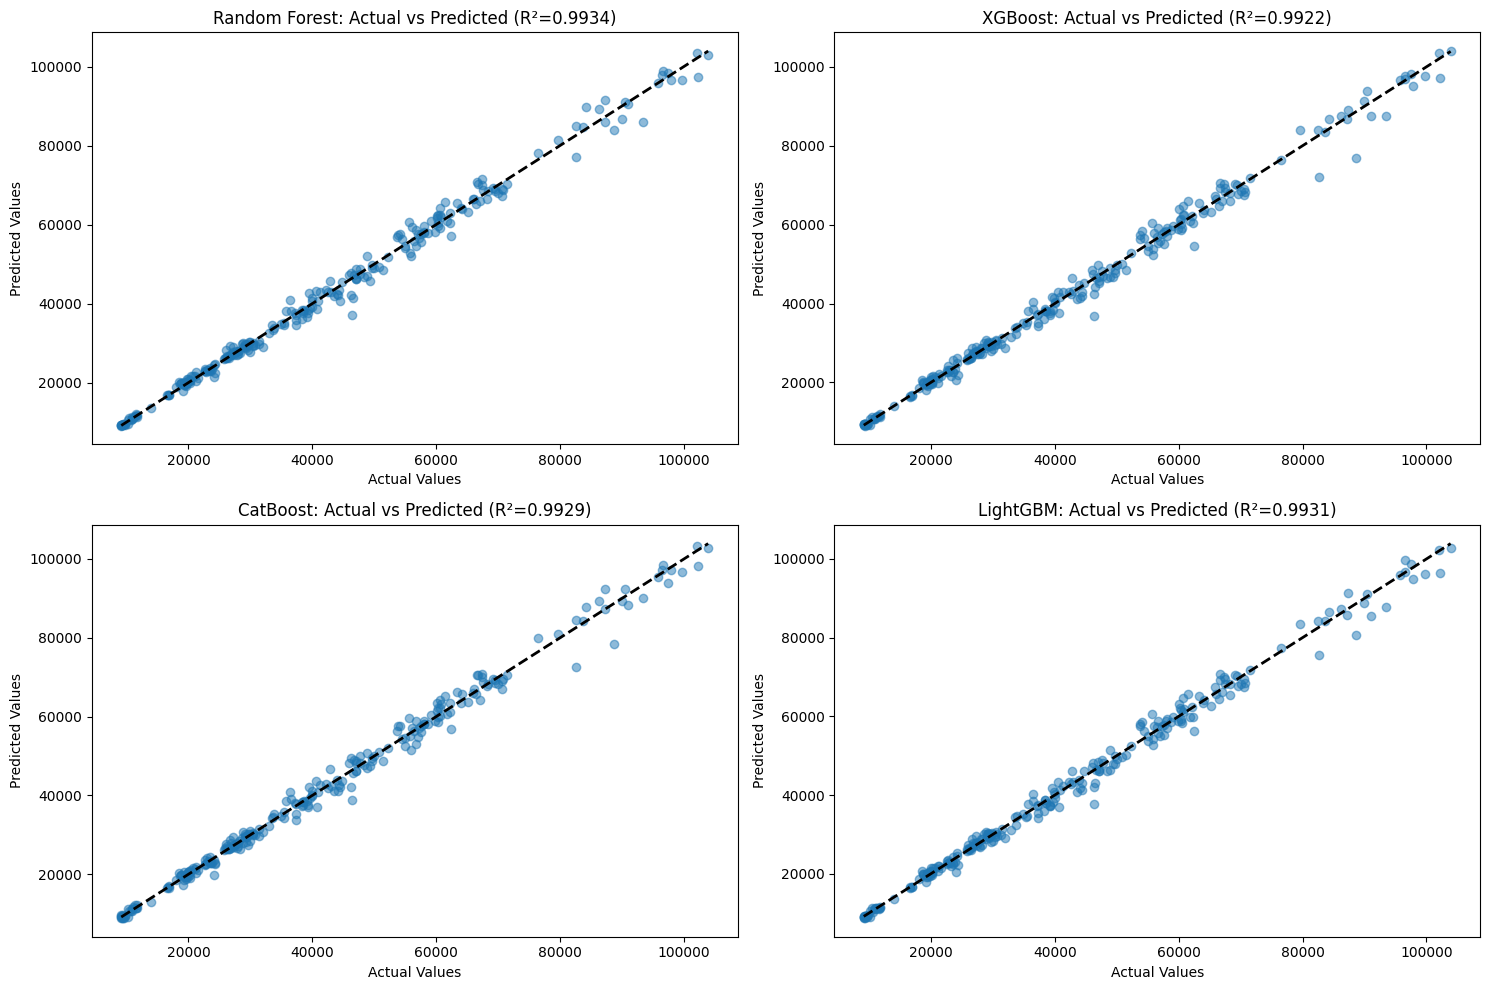

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train/test split (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# --- 1. Random Forest Hyperparameter Tuning ---
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_
print("Best RF Params:", rf_cv.best_params_)

y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest:")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"R²   : {r2_score(y_test, y_pred_rf):.4f}")

# --- 2. XGBoost Hyperparameter Tuning ---
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_cv = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_
print("\nBest XGBoost Params:", xgb_cv.best_params_)

y_pred_xgb = best_xgb.predict(X_test)
print("\nXGBoost:")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"R²   : {r2_score(y_test, y_pred_xgb):.4f}")

# --- 3. CatBoost Hyperparameter Tuning ---
cat_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

cat = CatBoostRegressor(random_seed=42, verbose=0)
cat_cv = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

cat_cv.fit(X_train, y_train)
best_cat = cat_cv.best_estimator_
print("\nBest CatBoost Params:", cat_cv.best_params_)

y_pred_cat = best_cat.predict(X_test)
print("\nCatBoost:")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_cat)):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_cat):.4f}")
print(f"R²   : {r2_score(y_test, y_pred_cat):.4f}")

# --- 4. LightGBM Hyperparameter Tuning ---
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 5, 10, 20],  # -1 means no limit
    'num_leaves': [31, 50, 100],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgbm = LGBMRegressor(random_state=42)
lgbm_cv = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

lgbm_cv.fit(X_train, y_train)
best_lgbm = lgbm_cv.best_estimator_
print("\nBest LightGBM Params:", lgbm_cv.best_params_)

y_pred_lgbm = best_lgbm.predict(X_test)
print("\nLightGBM:")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_lgbm)):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_lgbm):.4f}")
print(f"R²   : {r2_score(y_test, y_pred_lgbm):.4f}")

# --- Visualization ---
import matplotlib.pyplot as plt

# Plot actual vs predicted for all models
models = {
    "Random Forest": (y_pred_rf, best_rf),
    "XGBoost": (y_pred_xgb, best_xgb),
    "CatBoost": (y_pred_cat, best_cat),
    "LightGBM": (y_pred_lgbm, best_lgbm)
}

plt.figure(figsize=(15, 10))
for i, (name, (y_pred, model)) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name}: Actual vs Predicted (R²={r2_score(y_test, y_pred):.4f})')
plt.tight_layout()
plt.show()

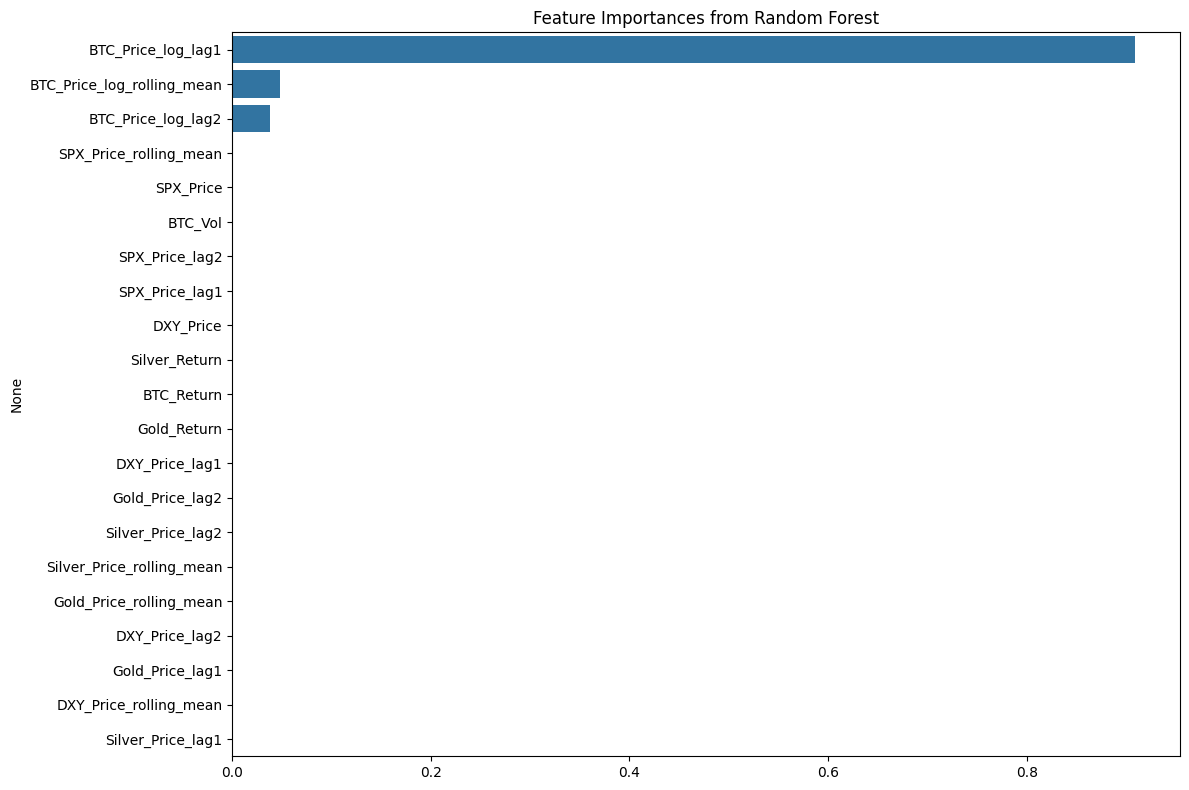

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Train a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


✅ 2. Select Top N Features

In [ ]:
# Let's select top 15 features
top_n = 15
top_features = feature_names[indices[:top_n]]

# Show the names of the top features
print(f"Top {top_n} features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

# Optionally, subset the DataFrame
X_top = X[top_features]


Top 15 features:
1. BTC_Price_log_lag1
2. BTC_Price_log_rolling_mean
3. BTC_Price_log_lag2
4. SPX_Price_rolling_mean
5. SPX_Price
6. BTC_Vol
7. SPX_Price_lag2
8. SPX_Price_lag1
9. DXY_Price
10. Silver_Return
11. BTC_Return
12. Gold_Return
13. DXY_Price_lag1
14. Gold_Price_lag2
15. Silver_Price_lag2


Parameter tuning for top N features

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import numpy as np
import warnings
import contextlib
import os
import sys

# Assume X_top, y, X_test, y_test, and top_features are already defined

def evaluate_model(name, model, X_eval, y_eval):
    preds = model.predict(X_eval)
    rmse = np.sqrt(mean_squared_error(y_eval, preds))
    mae = mean_absolute_error(y_eval, preds)
    r2 = r2_score(y_eval, preds)
    print(f"\n{name}:")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout, sys.stderr = devnull, devnull
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# --- Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_search.fit(X_top, y)
print("Best RF Params:", rf_search.best_params_)
evaluate_model("Random Forest", rf_search.best_estimator_, X_test[top_features], y_test)

# --- XGBoost ---
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_search.fit(X_top, y)
print("Best XGBoost Params:", xgb_search.best_params_)
evaluate_model("XGBoost", xgb_search.best_estimator_, X_test[top_features], y_test)

# --- CatBoost ---
cat_param_grid = {
    'iterations': [200, 300, 400],
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
cat = CatBoostRegressor(random_seed=42, verbose=0)
cat_search = RandomizedSearchCV(cat, cat_param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
cat_search.fit(X_top, y)
print("Best CatBoost Params:", cat_search.best_params_)
evaluate_model("CatBoost", cat_search.best_estimator_, X_test[top_features], y_test)

# --- LightGBM ---
lgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
lgb = LGBMRegressor(random_state=42, verbose=-1)  # Suppresses internal LightGBM output
lgb_search = RandomizedSearchCV(lgb, lgb_param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

with suppress_output():
    lgb_search.fit(X_top, y)

print("Best LightGBM Params:", lgb_search.best_params_)
evaluate_model("LightGBM", lgb_search.best_estimator_, X_test[top_features], y_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF Params: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}

Random Forest:
RMSE : 926.1490
MAE  : 603.8366
R²   : 0.9984
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

XGBoost:
RMSE : 1342.1266
MAE  : 928.9055
R²   : 0.9966
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CatBoost Params: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 3}

CatBoost:
RMSE : 1643.3181
MAE  : 1192.6839
R²   : 0.9949
Best LightGBM Params: {'subsample': 0.6, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

LightGBM:
RMSE : 735.8859
MAE  : 489.4597
R²   : 0.9990


TimeSeriesSplit(n_splits=5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best RF Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

Random Forest:
RMSE : 667.7122
MAE  : 429.5935
R²   : 0.9992
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

XGBoost:
RMSE : 1184.5629
MAE  : 840.2007
R²   : 0.9974
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CatBoost Params: {'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 400, 'depth': 3}

CatBoost:
RMSE : 1503.3638
MAE  : 1117.3975
R²   : 0.9958

Best LightGBM Params: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

LightGBM:
RMSE : 573.0383
MAE  : 398.6638
R²   : 0.9994


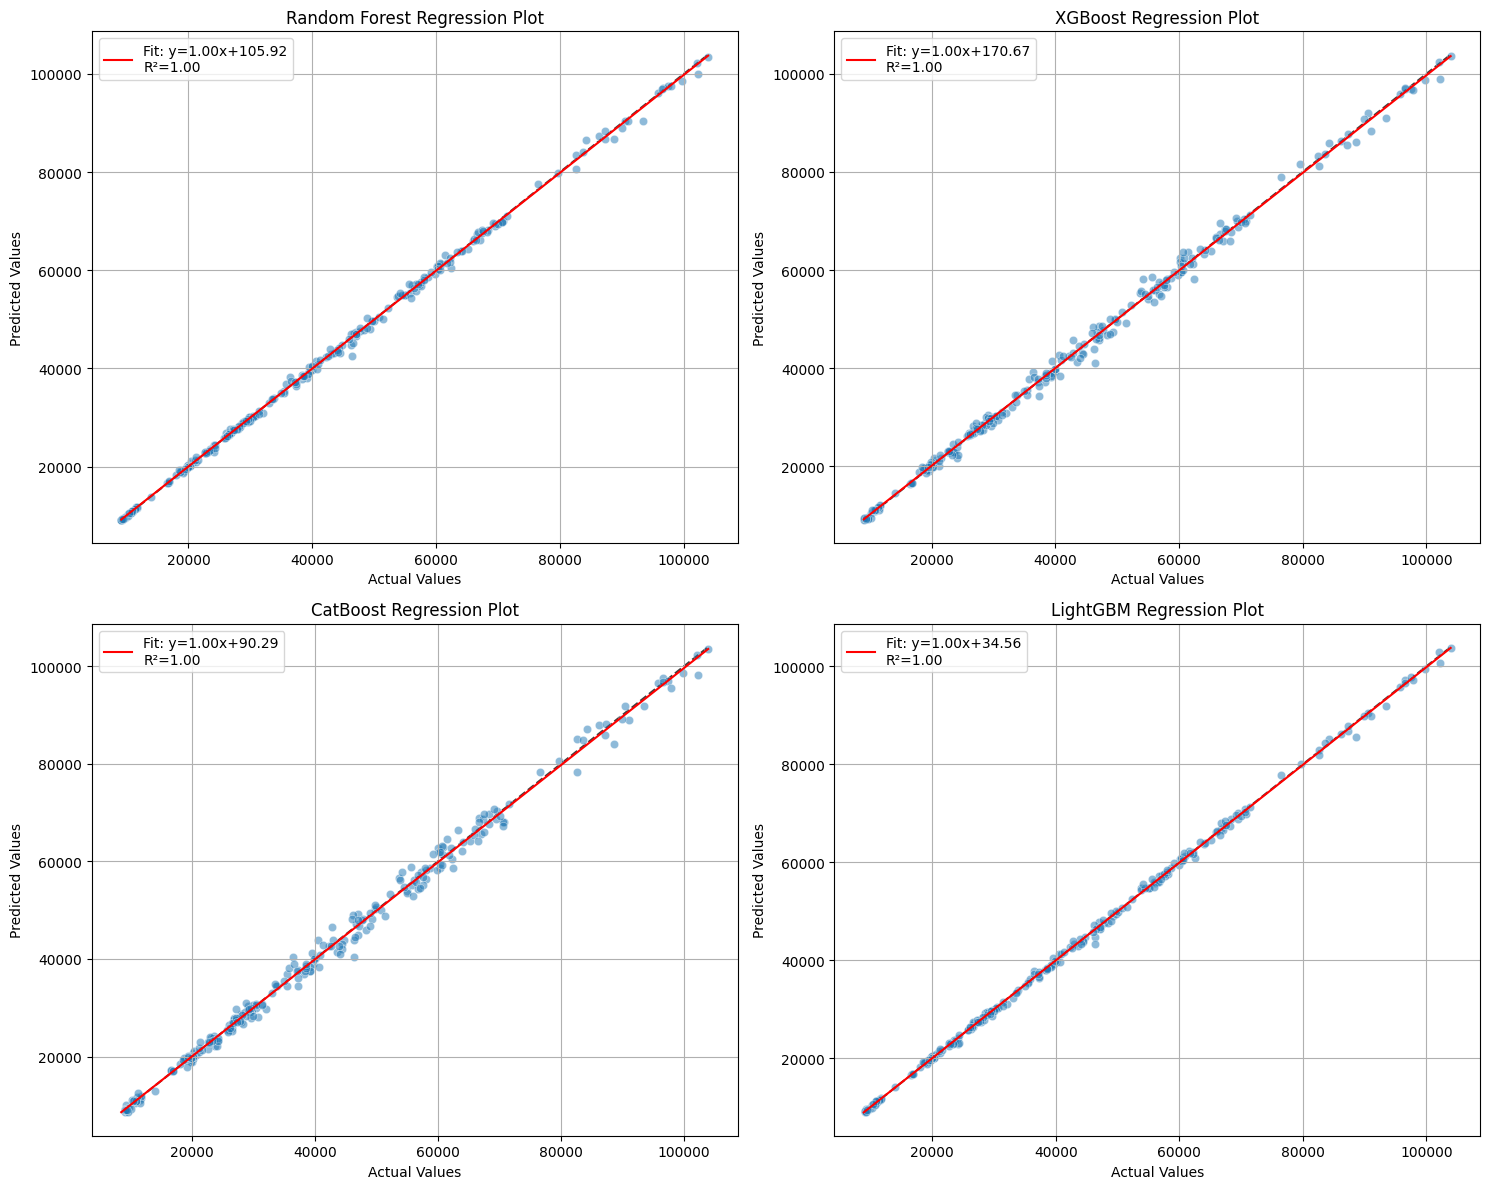

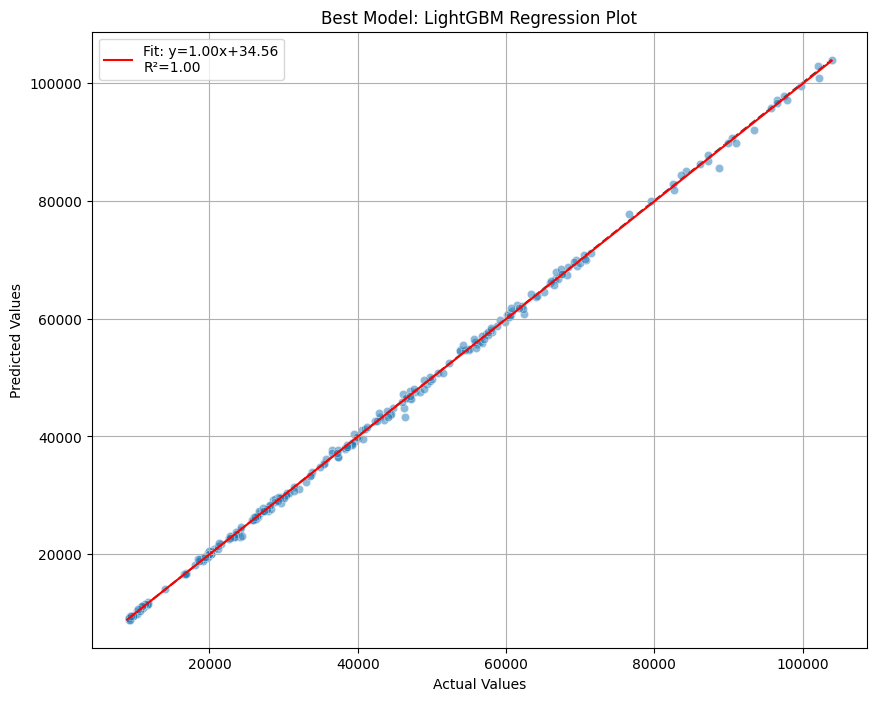

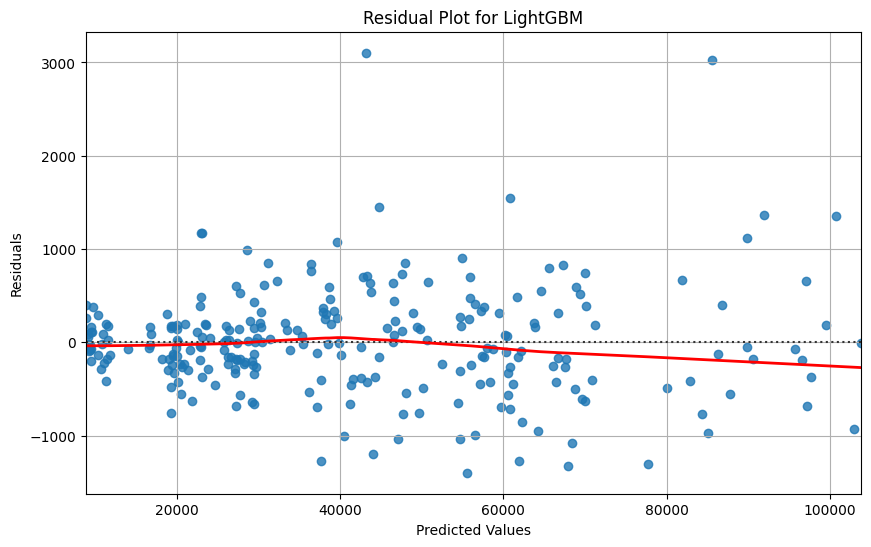

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
import contextlib
import os
import sys

# Suppress warnings
warnings.filterwarnings('ignore')

# Assume X_top, y, X_test, y_test, and top_features are already defined

# --- Utility Functions ---
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout, sys.stderr = devnull, devnull
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

def evaluate_model(name, model, X_eval, y_eval):
    preds = model.predict(X_eval)
    rmse = np.sqrt(mean_squared_error(y_eval, preds))
    mae = mean_absolute_error(y_eval, preds)
    r2 = r2_score(y_eval, preds)
    print(f"\n{name}:")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    return preds, r2

def plot_regression(y_true, y_pred, model_name, ax):
    # Scatter plot of actual vs predicted
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, ax=ax)

    # Add perfect prediction line
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

    # Calculate and plot regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
    line = slope * np.array(lims) + intercept
    ax.plot(lims, line, 'r', label=f'Fit: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}')

    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{model_name} Regression Plot')
    ax.legend()
    ax.grid(True)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# --- Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=30, cv=tscv,
                             scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_search.fit(X_top, y)
print("\nBest RF Params:", rf_search.best_params_)
rf_preds, rf_r2 = evaluate_model("Random Forest", rf_search.best_estimator_,
                                X_test[top_features], y_test)

# --- XGBoost ---
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=30, cv=tscv,
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_search.fit(X_top, y)
print("\nBest XGBoost Params:", xgb_search.best_params_)
xgb_preds, xgb_r2 = evaluate_model("XGBoost", xgb_search.best_estimator_,
                                  X_test[top_features], y_test)

# --- CatBoost ---
cat_param_grid = {
    'iterations': [200, 300, 400],
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
cat = CatBoostRegressor(random_seed=42, verbose=0)
cat_search = RandomizedSearchCV(cat, cat_param_grid, n_iter=30, cv=tscv,
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
cat_search.fit(X_top, y)
print("\nBest CatBoost Params:", cat_search.best_params_)
cat_preds, cat_r2 = evaluate_model("CatBoost", cat_search.best_estimator_,
                                  X_test[top_features], y_test)

# --- LightGBM ---
lgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
lgb = LGBMRegressor(random_state=42, verbose=-1)
lgb_search = RandomizedSearchCV(lgb, lgb_param_grid, n_iter=30, cv=tscv,
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

with suppress_output():
    lgb_search.fit(X_top, y)

print("\nBest LightGBM Params:", lgb_search.best_params_)
lgb_preds, lgb_r2 = evaluate_model("LightGBM", lgb_search.best_estimator_,
                                  X_test[top_features], y_test)

# --- Visualization ---
plt.figure(figsize=(15, 12))

models = {
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "CatBoost": cat_preds,
    "LightGBM": lgb_preds
}

# Generate regression plots
for i, (name, preds) in enumerate(models.items(), 1):
    ax = plt.subplot(2, 2, i)
    plot_regression(y_test, preds, name, ax)

plt.tight_layout()
plt.show()

# Find and plot best model
model_performance = {
    "Random Forest": rf_r2,
    "XGBoost": xgb_r2,
    "CatBoost": cat_r2,
    "LightGBM": lgb_r2
}

best_model_name = max(model_performance, key=model_performance.get)
best_preds = models[best_model_name]

# Detailed plot for best model
plt.figure(figsize=(10, 8))
ax = plt.gca()
plot_regression(y_test, best_preds, f"Best Model: {best_model_name}", ax)
plt.show()

# Residual plot for best model
residuals = y_test - best_preds
plt.figure(figsize=(10, 6))
sns.residplot(x=best_preds, y=residuals, lowess=True,
             line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {best_model_name}')
plt.grid(True)
plt.show()

# Return trained models if needed
trained_models = {
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
    "CatBoost": cat_search.best_estimator_,
    "LightGBM": lgb_search.best_estimator_
}

Predictions

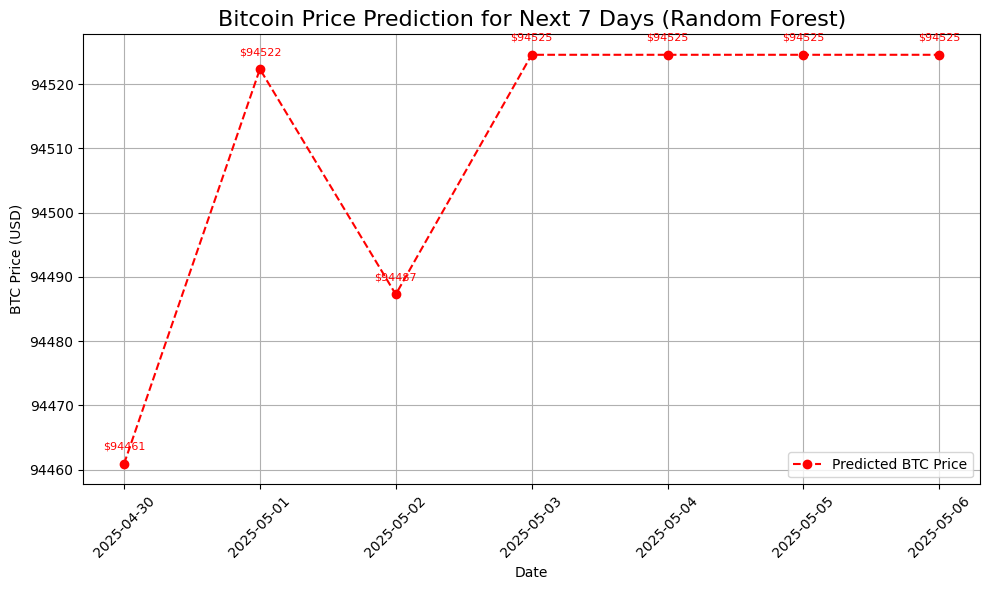


📈 Predicted BTC Prices for the Next 7 Days:
Day 1: $94460.88
Day 2: $94522.36
Day 3: $94487.28
Day 4: $94524.59
Day 5: $94524.59
Day 6: $94524.59
Day 7: $94524.59


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load cleaned dataset
df = pd.read_csv('/content/combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
df.dropna(inplace=True)

# 2. Define features and target
features = ['SPX_Price', 'DXY_Price', 'BTC_Vol',
            'BTC_Price_log_lag1', 'BTC_Price_log_lag2',
            'SPX_Price_lag1', 'SPX_Price_lag2',
            'DXY_Price_lag1', 'DXY_Price_lag2',
            'BTC_Price_log_rolling_mean', 'SPX_Price_rolling_mean', 'DXY_Price_rolling_mean',
            'BTC_Return',
            'Gold_Price_lag1', 'Gold_Price_lag2', 'Gold_Price_rolling_mean', 'Gold_Return',
            'Silver_Price_lag1', 'Silver_Price_lag2', 'Silver_Price_rolling_mean', 'Silver_Return']

X = df[features]
y = df['BTC_Price']

# 3. Train Random Forest on full data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 4. Predict the next 7 days
future_predictions = []
future_dates = []

# Start from the last row
latest_features = X.iloc[-1].copy()

for day in range(7):
    # Predict next day
    latest_features_df = latest_features.to_frame().T  # Keep as DataFrame
    pred = rf_model.predict(latest_features_df)[0]
    future_predictions.append(pred)
    future_dates.append(df.index[-1] + pd.Timedelta(days=day+1))

    # Update features for next prediction
    btc_log_pred = np.log1p(pred)

    # Shift lags
    latest_features['BTC_Price_log_lag2'] = latest_features['BTC_Price_log_lag1']
    latest_features['BTC_Price_log_lag1'] = btc_log_pred

    latest_features['SPX_Price_lag2'] = latest_features['SPX_Price_lag1']
    latest_features['SPX_Price_lag1'] = latest_features['SPX_Price_lag1']  # Assume flat

    latest_features['DXY_Price_lag2'] = latest_features['DXY_Price_lag1']
    latest_features['DXY_Price_lag1'] = latest_features['DXY_Price_lag1']  # Assume flat

    # Update rolling means safely
    past_btc_prices = [np.expm1(latest_features['BTC_Price_log_lag1']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),  # Approximate repeated
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2'])]

    rolling_mean = np.mean(past_btc_prices)
    latest_features['BTC_Price_log_rolling_mean'] = np.log1p(rolling_mean)

    # Keep SPX, DXY rolling means constant (or improve later)
    # Calculate BTC_Return safely
    previous_price = np.expm1(latest_features['BTC_Price_log_lag2'])
    if previous_price != 0:
        latest_features['BTC_Return'] = (pred - previous_price) / previous_price
    else:
        latest_features['BTC_Return'] = 0

# 5. Plotting only 7-day predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions,
         linestyle='--', marker='o', color='red', label='Predicted BTC Price')

for i, pred in enumerate(future_predictions):
    plt.annotate(f"${pred:.0f}", (future_dates[i], pred),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title('Bitcoin Price Prediction for Next 7 Days (Random Forest)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print predictions
print("\n📈 Predicted BTC Prices for the Next 7 Days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")


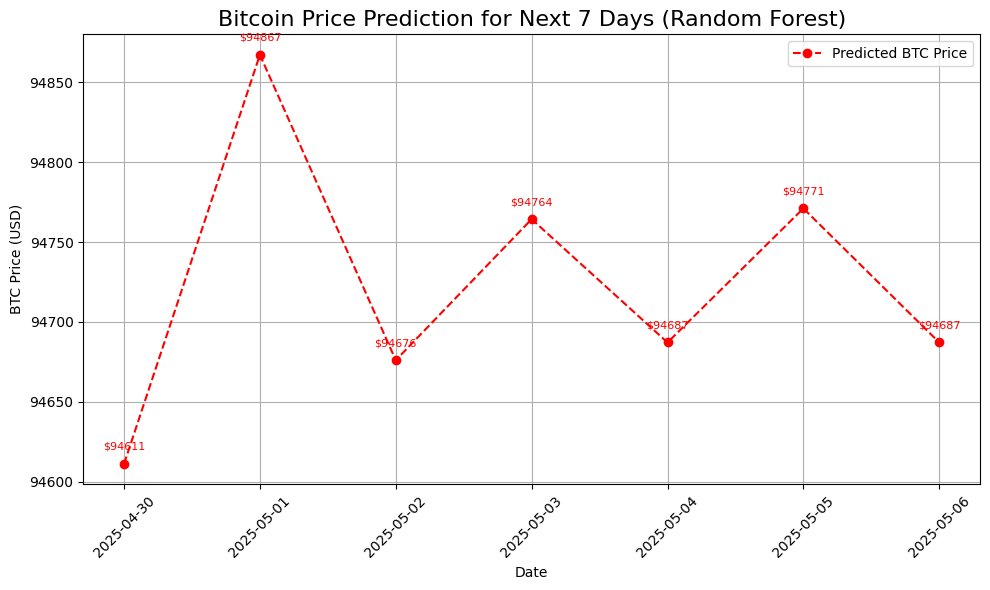


📈 Predicted BTC Prices for the Next 7 Days:
Day 1: $94611.19
Day 2: $94867.13
Day 3: $94676.04
Day 4: $94764.29
Day 5: $94687.14
Day 6: $94771.02
Day 7: $94687.14


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Load cleaned dataset
df = pd.read_csv('/content/combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
df.dropna(inplace=True)

# 2. Define features and target
features = ['SPX_Price', 'DXY_Price', 'BTC_Vol', 'BTC_Price_log_lag1', 'BTC_Price_log_lag2',
            'SPX_Price_lag1', 'SPX_Price_lag2', 'DXY_Price_lag1', 'DXY_Price_lag2',
            'BTC_Price_log_rolling_mean', 'SPX_Price_rolling_mean', 'DXY_Price_rolling_mean',
            'BTC_Return']

X = df[features]
y = df['BTC_Price']

# 3. Train Random Forest on full data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 4. Predict the next 7 days
future_predictions = []
future_dates = []

# Start from the last row
latest_features = X.iloc[-1].copy()

for day in range(7):
    # Predict next day
    latest_features_df = latest_features.to_frame().T  # Keep as DataFrame
    pred = rf_model.predict(latest_features_df)[0]
    future_predictions.append(pred)
    future_dates.append(df.index[-1] + pd.Timedelta(days=day+1))

    # Update features for next prediction
    btc_log_pred = np.log1p(pred)

    # Shift lags
    latest_features['BTC_Price_log_lag2'] = latest_features['BTC_Price_log_lag1']
    latest_features['BTC_Price_log_lag1'] = btc_log_pred

    latest_features['SPX_Price_lag2'] = latest_features['SPX_Price_lag1']
    latest_features['SPX_Price_lag1'] = latest_features['SPX_Price_lag1']  # Assume flat

    latest_features['DXY_Price_lag2'] = latest_features['DXY_Price_lag1']
    latest_features['DXY_Price_lag1'] = latest_features['DXY_Price_lag1']  # Assume flat

    # Update rolling means safely
    past_btc_prices = [np.expm1(latest_features['BTC_Price_log_lag1']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),  # Approximate repeated
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2']),
                       np.expm1(latest_features['BTC_Price_log_lag2'])]

    rolling_mean = np.mean(past_btc_prices)
    latest_features['BTC_Price_log_rolling_mean'] = np.log1p(rolling_mean)

    # Keep SPX, DXY rolling means constant (or improve later)
    # Calculate BTC_Return safely
    previous_price = np.expm1(latest_features['BTC_Price_log_lag2'])
    if previous_price != 0:
        latest_features['BTC_Return'] = (pred - previous_price) / previous_price
    else:
        latest_features['BTC_Return'] = 0

# 5. Plotting only 7-day predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions,
         linestyle='--', marker='o', color='red', label='Predicted BTC Price')

for i, pred in enumerate(future_predictions):
    plt.annotate(f"${pred:.0f}", (future_dates[i], pred),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title('Bitcoin Price Prediction for Next 7 Days (Random Forest)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print predictions
print("\n📈 Predicted BTC Prices for the Next 7 Days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")


Deep Learning Models

Pre Processing

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('combined_macro_btc_data (1).csv')

# Define features and target
exclude_columns = ['Date', 'BTC_Price']
features = [col for col in df.columns if col not in exclude_columns]
target = 'BTC_Price'

X = df[features]
y = df[target]

# Handle missing values
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("\nFeature Importance (All Features):\n", feature_importance)

# Select top 15 features
N = 15
top_features = feature_importance['Feature'].head(N).tolist()
print(f"\nTop {N} Features:\n", top_features)

# Filter dataset to include only top 15 features
X_top = df[top_features]
X_top_scaled = scaler.fit_transform(X_top)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)

# Save the data in variables (no file saving)
train_data = X_train
test_data = X_test
train_target = y_train
test_target = y_test

# Print the shapes of the datasets to confirm
print(f"\nX_train shape: {train_data.shape}")
print(f"X_test shape: {test_data.shape}")
print(f"y_train shape: {train_target.shape}")
print(f"y_test shape: {test_target.shape}")



Feature Importance (All Features):
                        Feature  Importance
25               BTC_Price_log    0.910753
1                     BTC_High    0.047325
31          BTC_Price_log_lag2    0.015937
2                      BTC_Low    0.009141
0                     BTC_Open    0.008615
26          BTC_Price_log_lag1    0.006268
36  BTC_Price_log_rolling_mean    0.001847
5                    SPX_Price    0.000007
7                     SPX_High    0.000007
27              SPX_Price_lag1    0.000006
37      SPX_Price_rolling_mean    0.000006
24              Silver_Change%    0.000005
28              DXY_Price_lag1    0.000005
40   Silver_Price_rolling_mean    0.000004
3                      BTC_Vol    0.000004
8                      SPX_Low    0.000004
4                  BTC_Change%    0.000004
12                    DXY_High    0.000004
15                  Gold_Price    0.000003
14                 DXY_Change%    0.000003
34             Gold_Price_lag2    0.000003
41               

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam

# Use in-memory variables instead of reading from CSV
X_train = train_data
X_test = test_data
y_train = train_target.values  # Ensure numpy array
y_test = test_target.values

### ANN Model ###
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nANN Model Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

### LSTM Model ###
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()

mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print("\nLSTM Model Performance:")
print(f"MAE: {mae_lstm:.2f}, MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}, R2: {r2_lstm:.2f}")

### GRU Model ###
model_gru = Sequential([
    GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_gru = model_gru.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

y_pred_gru = model_gru.predict(X_test_lstm).flatten()

mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("\nGRU Model Performance:")
print(f"MAE: {mae_gru:.2f}, MSE: {mse_gru:.2f}, RMSE: {rmse_gru:.2f}, R2: {r2_gru:.2f}")

### Deep ANN ###
model_ann_deep = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ann_deep.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_ann_deep = model_ann_deep.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

y_pred_ann_deep = model_ann_deep.predict(X_test).flatten()

mae_ann_deep = mean_absolute_error(y_test, y_pred_ann_deep)
mse_ann_deep = mean_squared_error(y_test, y_pred_ann_deep)
rmse_ann_deep = np.sqrt(mse_ann_deep)
r2_ann_deep = r2_score(y_test, y_pred_ann_deep)

print("\nDeep ANN Model Performance:")
print(f"MAE: {mae_ann_deep:.2f}, MSE: {mse_ann_deep:.2f}, RMSE: {rmse_ann_deep:.2f}, R2: {r2_ann_deep:.2f}")

### Performance Summary Table ###
performance_data = {
    "Model": ["ANN", "LSTM", "GRU", "Deep ANN"],
    "MAE": [mae, mae_lstm, mae_gru, mae_ann_deep],
    "MSE": [mse, mse_lstm, mse_gru, mse_ann_deep],
    "RMSE": [rmse, rmse_lstm, rmse_gru, rmse_ann_deep],
    "R2 Score": [r2, r2_lstm, r2_gru, r2_ann_deep]
}

performance_df = pd.DataFrame(performance_data).round(4)

print("\nModel Performance Summary:\n")
print(performance_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 2397876224.0000 - val_loss: 2265527808.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2214656256.0000 - val_loss: 2256577536.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2316605696.0000 - val_loss: 2206600960.0000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2332345344.0000 - val_loss: 2041707648.0000
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1946577024.0000 - val_loss: 1678157952.0000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1683439744.0000 - val_loss: 1135463296.0000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 972782144.0000 - val_loss: 640150400.0000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 584531840.0000 - val_loss: 407430784.0000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 387649120.0000 - val_loss: 339542688.0000
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 332552384.0000 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 2184389888.0000 - val_loss: 1502637696.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1318029696.0000 - val_loss: 278584416.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 194744656.0000 - val_loss: 29331828.0000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 51769796.0000 - val_loss: 10402744.0000
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 34339464.0000 - val_loss: 8183445.0000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 26844866.0000 - val_loss: 14353645.0000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 27597792.0000 - val_loss: 5136771.5000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 22716484.0000 - val_loss: 6818886.0000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 23762768.0000 - val_loss: 3468346.0000
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 21706474.0000 - val_loss: 7055562.5000
Epoch 11

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 2247425280.0000 - val_loss: 1874579712.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 806604160.0000 - val_loss: 73312032.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 118254440.0000 - val_loss: 21500702.0000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 52375988.0000 - val_loss: 13123385.0000
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 34380084.0000 - val_loss: 14715424.0000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 30589912.0000 - val_loss: 16483196.0000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 34239360.0000 - val_loss: 4328526.5000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 29838426.0000 - val_loss: 6997911.5000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 23994828.0000 - val_loss: 4001749.7500
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 22894014.0000 - val_loss: 4414100.0000
Epoch 11/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2308881664.0000 - val_loss: 2263865856.0000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2256412928.0000 - val_loss: 2197775872.0000
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2032160384.0000 - val_loss: 1556700160.0000
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1107716480.0000 - val_loss: 427514176.0000
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 423184192.0000 - val_loss: 319003552.0000
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 342242432.0000 - val_loss: 215246208.0000
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 218529904.0000 - val_loss: 139270000.0000
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 164877104.0000 - val_loss: 90704056.0000
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 119199696.0000 - val_loss: 63594864.0000
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97541808.0000 - val_loss: 442232

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Use already preprocessed variables
X_train = train_data
X_test = test_data
y_train = train_target.values
y_test = test_target.values

# Reshape for models that need 3D input
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Store results
results = []

def evaluate_model(model, X_t, X_v, name):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_t, y_train, validation_data=(X_v, y_test), epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_v).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape*100:.2f}%")

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2,
        "MAPE (%)": mape * 100
    })

### ANN ###
ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(ann, X_train, X_test, "ANN")

### Deep ANN ###
deep_ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(deep_ann, X_train, X_test, "Deep ANN")

### LSTM ###
lstm = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(lstm, X_train_seq, X_test_seq, "LSTM")

### GRU ###
gru = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(gru, X_train_seq, X_test_seq, "GRU")

### CNN-LSTM ###
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(cnn_lstm, X_train_seq, X_test_seq, "CNN-LSTM")

### Final Performance Summary ###
performance_df = pd.DataFrame(results).round(4)
print("\nFinal Model Performance Summary:\n")
print(performance_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

ANN Performance:
MAE: 1582.22, MSE: 4117947.91, RMSE: 2029.27, R2: 0.9923, MAPE: 4.59%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Deep ANN Performance:
MAE: 1480.94, MSE: 3967207.56, RMSE: 1991.79, R2: 0.9926, MAPE: 3.82%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

LSTM Performance:
MAE: 8012.18, MSE: 82783389.52, RMSE: 9098.54, R2: 0.8449, MAPE: 19.41%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

GRU Performance:
MAE: 5577.30, MSE: 44635559.43, RMSE: 6680.98, R2: 0.9164, MAPE: 12.20%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

CNN-LSTM Performance:
MAE: 3868.52, MSE: 21063338.09, RMSE: 4589.48, R2: 0.9605, MAPE: 8.84%

Final Model Performance Summary:

      Model        MAE           MSE       RMSE  R2 Score  MAPE (%)
0       ANN  1582.2177  4.117948e+06  2029.2728    0.9923    4.5903
1  Deep ANN  1480.9393  3.967208e+06  1991.7850    0.9926    3.8222
2      LSTM  8012.1781  8.278339e+07  9098.5378    0.8449   19.4064
3       GRU  5577.2987  4.463556e+07  6680.9849    0.9164   12.1985
4  CNN-LSTM  3868.5170  2.106334e+07  4589.4812    0.9605    8.8430


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Assuming train_data and test_data are already loaded/preprocessed
# Also, assuming train_target and test_target are your target values (labels)

# Scale the features (X) and target (y) separately
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(train_data)
X_test_scaled = scaler_X.transform(test_data)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(train_target.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(test_target.values.reshape(-1, 1)).flatten()

# Reshape the input for RNN models
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Model evaluation function
def evaluate_model(model, X_t, X_v, y_t, y_v, name):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=32, verbose=0)

    # Predict the scaled target values
    y_pred_scaled = model.predict(X_v).flatten()

    # Invert scaling
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_v, y_pred)
    mse = mean_squared_error(y_v, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_v, y_pred)
    mape = mean_absolute_percentage_error(y_v, y_pred)

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape*100:.2f}%")
    return {
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2,
        "MAPE (%)": mape * 100
    }

# Store results
results = []

### Bi-LSTM Model ###
bi_lstm = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X_train_seq.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='relu')),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

results.append(evaluate_model(bi_lstm, X_train_seq, X_test_seq, y_train_scaled, y_test_scaled, "Bi-LSTM"))

### Bi-GRU Model ###
bi_gru = Sequential([
    Bidirectional(GRU(128, activation='relu', return_sequences=True), input_shape=(X_train_seq.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(64, activation='relu')),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

results.append(evaluate_model(bi_gru, X_train_seq, X_test_seq, y_train_scaled, y_test_scaled, "Bi-GRU"))

# Final performance summary
performance_df = pd.DataFrame(results).round(4)
print("\nFinal Model Performance Summary:\n")
print(performance_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step

Bi-LSTM Performance:
MAE: 38529.85, MSE: 1982989396.94, RMSE: 44530.77, R2: -36633931049.5157, MAPE: 12171001.29%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step

Bi-GRU Performance:
MAE: 39377.97, MSE: 2099855751.02, RMSE: 45824.18, R2: -38792930973.6047, MAPE: 12549423.96%

Final Model Performance Summary:

     Model         MAE           MSE        RMSE      R2 Score      MAPE (%)
0  Bi-LSTM  38529.8525  1.982989e+09  44530.7691 -3.663393e+10  1.217100e+07
1   Bi-GRU  39377.9743  2.099856e+09  45824.1830 -3.879293e+10  1.254942e+07


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Use already preprocessed variables
X_train = train_data
X_test = test_data
y_train = train_target.values
y_test = test_target.values

# Reshape for models that need 3D input
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Store results
results = []

def evaluate_model(model, X_t, X_v, name):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_t, y_train, validation_data=(X_v, y_test), epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_v).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape*100:.2f}%")

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2,
        "MAPE (%)": mape * 100
    })

### ANN ###
ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(ann, X_train, X_test, "ANN")

### Deep ANN ###
deep_ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(deep_ann, X_train, X_test, "Deep ANN")

### LSTM ###
lstm = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(lstm, X_train_seq, X_test_seq, "LSTM")

### GRU ###
gru = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(gru, X_train_seq, X_test_seq, "GRU")

### CNN-LSTM ###
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
evaluate_model(cnn_lstm, X_train_seq, X_test_seq, "CNN-LSTM")

### Final Performance Summary ###
performance_df = pd.DataFrame(results).round(4)
print("\nFinal Model Performance Summary:\n")
print(performance_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

ANN Performance:
MAE: 1852.62, MSE: 5637751.46, RMSE: 2374.39, R2: 0.9894, MAPE: 5.24%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Deep ANN Performance:
MAE: 1243.09, MSE: 2767612.10, RMSE: 1663.61, R2: 0.9948, MAPE: 3.06%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

LSTM Performance:
MAE: 6923.05, MSE: 62539137.17, RMSE: 7908.17, R2: 0.8829, MAPE: 17.09%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

GRU Performance:
MAE: 5326.14, MSE: 38885021.96, RMSE: 6235.79, R2: 0.9272, MAPE: 12.50%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

CNN-LSTM Performance:
MAE: 4636.65, MSE: 29549215.06, RMSE: 5435.92, R2: 0.9447, MAPE: 10.79%

Final Model Performance Summary:

      Model        MAE           MSE       RMSE  R2 Score  MAPE (%)
0       ANN  1852.6180  5.637751e+06  2374.3950    0.9894    5.2425
1  Deep ANN  1243.0852  2.767612e+06  1663.6142    0.9948    3.0551
2      LSTM  6923.0471  6.253914e+07  7908.1690    0.8829   17.0907
3       GRU  5326.1428  3.888502e+07  6235.7856    0.9272   12.4980
4  CNN-LSTM  4636.6542  2.954922e+07  5435.9190    0.9447   10.7853


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


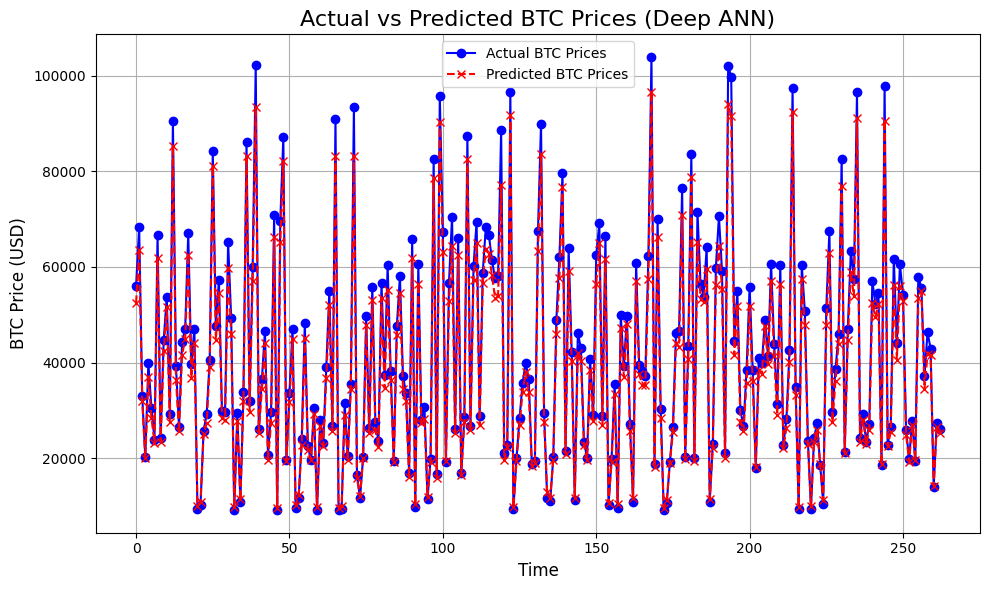

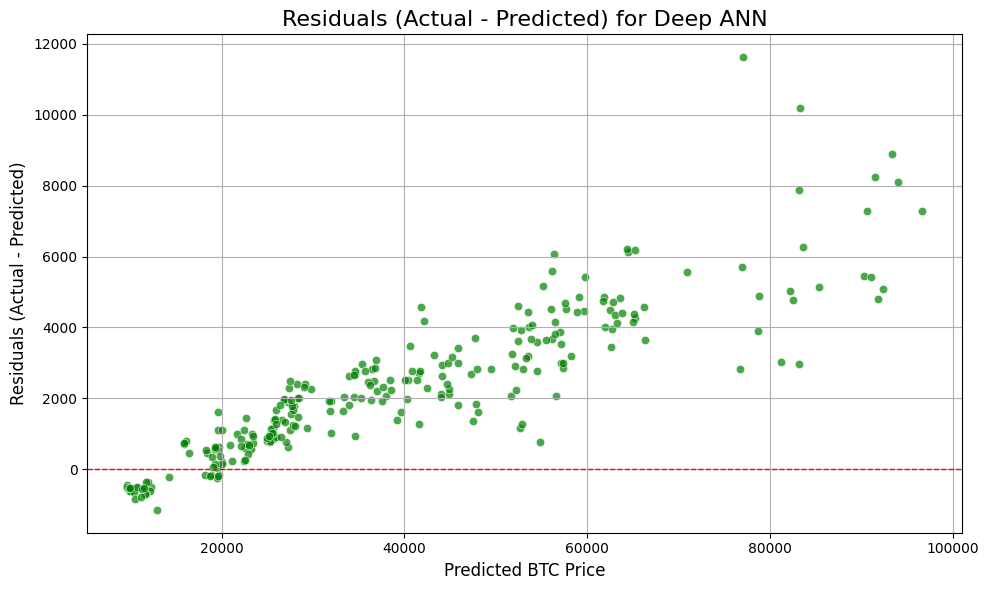

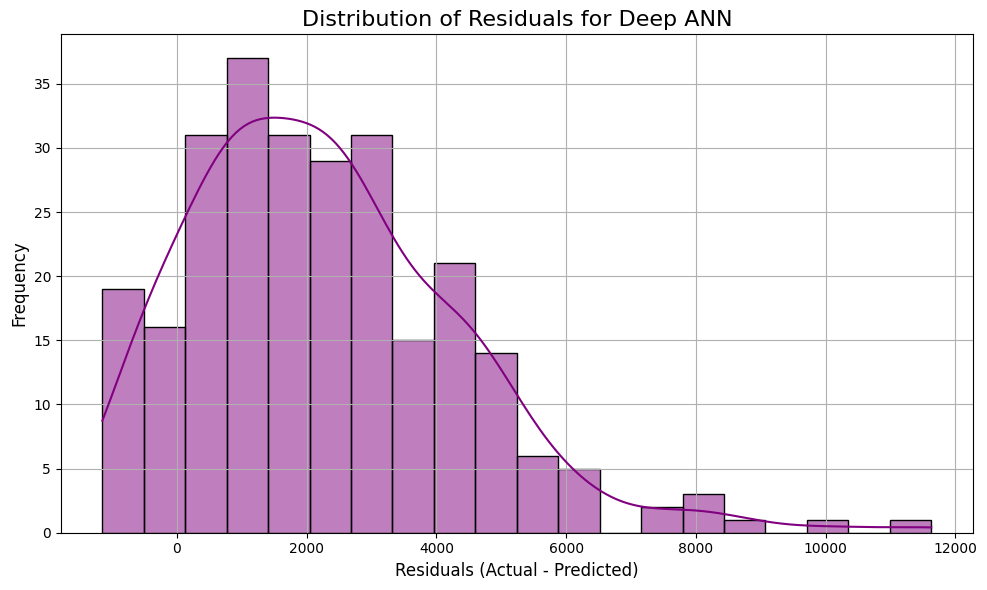


Best Model - Deep ANN Performance Metrics:
MAE: 2409.72, MSE: 9533385.51, RMSE: 3087.62, R2: 0.9821, MAPE: 5.28%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Best performing model (Let's assume Deep ANN for this example)
best_model = deep_ann

# Evaluate the model again to get the predictions
best_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
y_pred = best_model.predict(X_test).flatten()

# 1. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual BTC Prices', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicted BTC Prices', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted BTC Prices (Deep ANN)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('BTC Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residual Plot (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals (Actual - Predicted) for Deep ANN', fontsize=16)
plt.xlabel('Predicted BTC Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residual Distribution Plot (for checking normality)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=20)
plt.title('Distribution of Residuals for Deep ANN', fontsize=16)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Performance Metrics (for reference)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nBest Model - Deep ANN Performance Metrics:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape*100:.2f}%")


<ipython-input-15-bcddec0df1ef>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


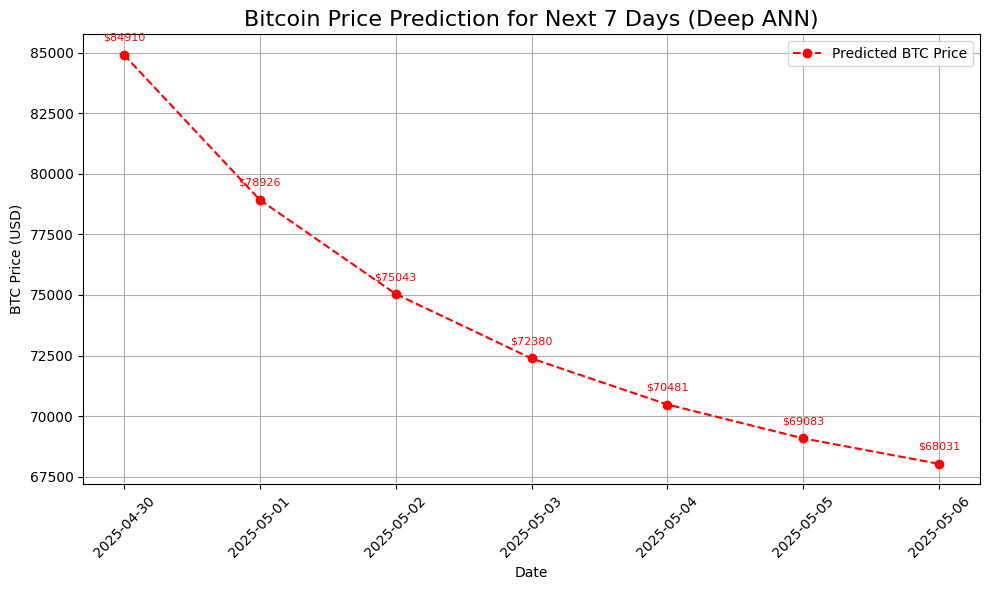


📈 Predicted BTC Prices for the Next 7 Days:
Day 1: $84910.11
Day 2: $78926.34
Day 3: $75042.51
Day 4: $72380.44
Day 5: $70480.68
Day 6: $69083.19
Day 7: $68031.10


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# 1. Load cleaned dataset
df = pd.read_csv('combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
df.dropna(inplace=True)

# 2. Define features and target
features = ['SPX_Price', 'DXY_Price', 'BTC_Vol', 'BTC_Price_log_lag1', 'BTC_Price_log_lag2',
            'SPX_Price_lag1', 'SPX_Price_lag2', 'DXY_Price_lag1', 'DXY_Price_lag2',
            'BTC_Price_log_rolling_mean', 'SPX_Price_rolling_mean', 'DXY_Price_rolling_mean',
            'BTC_Return']

X = df[features]
y = df['BTC_Price']

# 3. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train the Deep ANN model
deep_ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
deep_ann.compile(optimizer='adam', loss='mse')
deep_ann.fit(X_scaled, y, epochs=100, batch_size=32, verbose=0)

# 5. Predict the next 7 days
future_predictions = []
future_dates = []

# Start from the last row of the dataset
latest_features = X.iloc[-1].copy()

for day in range(7):
    # Prepare the data for the model to predict
    latest_features_scaled = scaler.transform([latest_features])

    # Predict the next day's BTC price
    pred = deep_ann.predict(latest_features_scaled)[0][0]
    future_predictions.append(pred)
    future_dates.append(df.index[-1] + pd.Timedelta(days=day+1))

    # Update the features for the next prediction
    btc_log_pred = np.log1p(pred)

    # Shift lags
    latest_features['BTC_Price_log_lag2'] = latest_features['BTC_Price_log_lag1']
    latest_features['BTC_Price_log_lag1'] = btc_log_pred

    latest_features['SPX_Price_lag2'] = latest_features['SPX_Price_lag1']
    latest_features['SPX_Price_lag1'] = latest_features['SPX_Price_lag1']  # Assume flat

    latest_features['DXY_Price_lag2'] = latest_features['DXY_Price_lag1']
    latest_features['DXY_Price_lag1'] = latest_features['DXY_Price_lag1']  # Assume flat

    # Update rolling means safely
    past_btc_prices = [np.expm1(latest_features['BTC_Price_log_lag1']),
                       np.expm1(latest_features['BTC_Price_log_lag2'])]

    rolling_mean = np.mean(past_btc_prices)
    latest_features['BTC_Price_log_rolling_mean'] = np.log1p(rolling_mean)

    # Calculate BTC_Return safely
    previous_price = np.expm1(latest_features['BTC_Price_log_lag2'])
    if previous_price != 0:
        latest_features['BTC_Return'] = (pred - previous_price) / previous_price
    else:
        latest_features['BTC_Return'] = 0

# 6. Plotting the 7-day predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions, linestyle='--', marker='o', color='red', label='Predicted BTC Price')

for i, pred in enumerate(future_predictions):
    plt.annotate(f"${pred:.0f}", (future_dates[i], pred), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title('Bitcoin Price Prediction for Next 7 Days (Deep ANN)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Print predictions
print("\n📈 Predicted BTC Prices for the Next 7 Days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")


<ipython-input-1-8edf4dab5644>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/content/combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2256813312.0000
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2233021184.0000
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1391565184.0000
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 370250176.0000
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 200762512.0000
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 138722832.0000
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 115141544.0000
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 99812960.0000 
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 82578560.0000
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81605952.0000
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 83751280.0000
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81512752.0000
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67392776.0000
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━

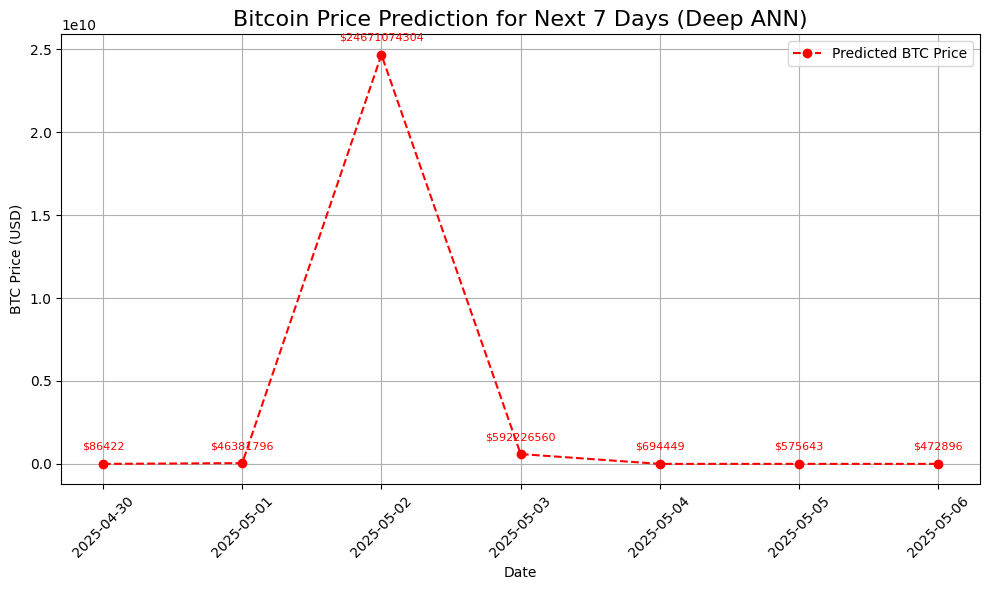


📈 Predicted BTC Prices for the Next 7 Days:
Day 1: $86421.86
Day 2: $46381796.00
Day 3: $24671074304.00
Day 4: $592226560.00
Day 5: $694449.31
Day 6: $575642.69
Day 7: $472895.72


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# 1. Load cleaned dataset
df = pd.read_csv('/content/combined_macro_btc_data (1).csv', parse_dates=True, index_col=0)
df.dropna(inplace=True)

# 2. Define features and target
features = ['SPX_Price', 'DXY_Price', 'BTC_Vol',
            'BTC_Price_log_lag1', 'BTC_Price_log_lag2',
            'SPX_Price_lag1', 'SPX_Price_lag2',
            'DXY_Price_lag1', 'DXY_Price_lag2',
            'BTC_Price_log_rolling_mean', 'SPX_Price_rolling_mean', 'DXY_Price_rolling_mean',
            'BTC_Return',
            'Gold_Price_lag1', 'Gold_Price_lag2', 'Gold_Price_rolling_mean', 'Gold_Return',
            'Silver_Price_lag1', 'Silver_Price_lag2', 'Silver_Price_rolling_mean', 'Silver_Return']

X = df[features]
y = df['BTC_Price']

# 3. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Build and train the Deep ANN model
deep_ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

deep_ann.compile(optimizer='adam', loss='mse')
deep_ann.fit(X_scaled, y, epochs=100, batch_size=32, verbose=1)

# 5. Predict the next 7 days
future_predictions = []
future_dates = []

# Start from the last row (scaled)
latest_features = X_scaled[-1].copy()

for day in range(7):
    # Predict next day
    pred = deep_ann.predict(latest_features.reshape(1, -1))[0][0]
    future_predictions.append(pred)
    future_dates.append(df.index[-1] + pd.Timedelta(days=day+1))

    # Update features for next prediction
    btc_log_pred = np.log1p(pred)

    # Create new feature vector
    new_features = np.zeros_like(latest_features)

    # Copy the previous features with appropriate shifts
    # SPX and DXY features (assuming they remain constant)
    new_features[0] = latest_features[0]  # SPX_Price (same as before)
    new_features[1] = latest_features[1]  # DXY_Price (same as before)
    new_features[2] = latest_features[2]  # BTC_Vol (same as before)

    # BTC lags
    new_features[3] = btc_log_pred  # BTC_Price_log_lag1 (new prediction)
    new_features[4] = latest_features[3]  # BTC_Price_log_lag2 (previous lag1)

    # SPX lags
    new_features[5] = latest_features[0]  # SPX_Price_lag1 (current SPX)
    new_features[6] = latest_features[5]  # SPX_Price_lag2 (previous SPX lag1)

    # DXY lags
    new_features[7] = latest_features[1]  # DXY_Price_lag1 (current DXY)
    new_features[8] = latest_features[7]  # DXY_Price_lag2 (previous DXY lag1)

    # Rolling means - recalculate BTC rolling mean
    past_btc_prices = [pred, np.expm1(latest_features[3]), np.expm1(latest_features[4])]
    rolling_mean = np.mean(past_btc_prices)
    new_features[9] = np.log1p(rolling_mean)

    # Keep SPX and DXY rolling means constant
    new_features[10] = latest_features[10]  # SPX_Price_rolling_mean
    new_features[11] = latest_features[11]  # DXY_Price_rolling_mean

    # BTC Return
    previous_price = np.expm1(latest_features[4])  # using lag2 as previous price
    if previous_price != 0:
        new_features[12] = (pred - previous_price) / previous_price
    else:
        new_features[12] = 0

    # Gold features (assuming constant)
    new_features[13:17] = latest_features[13:17]

    # Silver features (assuming constant)
    new_features[17:21] = latest_features[17:21]

    # Update latest_features for next iteration
    latest_features = new_features.copy()

# 6. Plotting only 7-day predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_predictions,
         linestyle='--', marker='o', color='red', label='Predicted BTC Price')

for i, pred in enumerate(future_predictions):
    plt.annotate(f"${pred:.0f}", (future_dates[i], pred),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title('Bitcoin Price Prediction for Next 7 Days (Deep ANN)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print predictions
print("\n📈 Predicted BTC Prices for the Next 7 Days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")